In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'higgs-boson'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
out = "./data/HIGGS.csv"

In [5]:
names = ["target", "lepton_pT", "lepton_eta", "lepton_phi", "missing_energy_magnitude", "missing_energy_phi", "jet_1_pt", "jet_1_eta", "jet_1_phi", "jet_1_b_tag", "jet_2_pt", "jet_2_eta", "jet_2_phi", "jet_2_b_tag", "jet_3_pt", "jet_3_eta", "jet_3_phi", "jet_3_b_tag", "jet_4_pt", "jet_4_eta", "jet_4_phi", "jet_4_b_tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]

In [6]:
train = pd.read_csv(out, header=None, names=names, nrows=10_000_000)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [7]:
train.head()

,target,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,Set
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678,train
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343,train
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118,train
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904,train
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487,train


In [8]:
train.shape

(10000000, 30)

In [9]:
target = 'target'

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [10]:
# nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train.columns):
    if types[col] == 'object':  # or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train[col].fillna(train.loc[train_indices, col].mean(), inplace=True)

 97%|█████████▋| 29/30 [00:07<00:00,  3.74it/s]

Set 3


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]


# Define categorical features for categorical embeddings

In [11]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [12]:
BS = 16384

In [13]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [14]:
max_epochs = 100

In [15]:
clf = TabNetClassifier(
    n_d=64, n_a=64,
    n_steps=5,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        max_lr=0.05,
        steps_per_epoch=int(X_train.shape[0] / BS),
        epochs=max_epochs,
        is_batch_level=True),
    scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
#     scheduler_params={"base_lr": 2e-2, "max_lr": 1e-1},
#     scheduler_fn=torch.optim.lr_scheduler.CyclicLR,
    mask_type='entmax' # "sparsemax"
  )

Device used : cuda


# Training

In [16]:
train.head()

,target,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,Set
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678,1
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343,1
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118,1
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904,1
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487,1


In [17]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=100 , patience=20,
    batch_size=16384, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=True
) 

epoch 0  | loss: 0.64734 | train_auc: 0.77064 | valid_auc: 0.77058 |  0:05:05s
epoch 1  | loss: 0.56659 | train_auc: 0.79379 | valid_auc: 0.79414 |  0:10:18s
epoch 2  | loss: 0.54327 | train_auc: 0.81134 | valid_auc: 0.81177 |  0:15:24s
epoch 3  | loss: 0.5292  | train_auc: 0.81755 | valid_auc: 0.81783 |  0:20:31s
epoch 4  | loss: 0.5218  | train_auc: 0.82362 | valid_auc: 0.82371 |  0:25:44s
epoch 5  | loss: 0.51634 | train_auc: 0.82682 | valid_auc: 0.8268  |  0:30:57s
epoch 6  | loss: 0.51129 | train_auc: 0.83082 | valid_auc: 0.83034 |  0:36:15s
epoch 7  | loss: 0.50547 | train_auc: 0.83552 | valid_auc: 0.83504 |  0:41:27s
epoch 8  | loss: 0.49956 | train_auc: 0.83985 | valid_auc: 0.83926 |  0:46:39s
epoch 9  | loss: 0.49525 | train_auc: 0.84397 | valid_auc: 0.84334 |  0:51:50s
epoch 10 | loss: 0.49162 | train_auc: 0.84598 | valid_auc: 0.84523 |  0:57:02s
epoch 11 | loss: 0.48985 | train_auc: 0.84472 | valid_auc: 0.84397 |  1:02:16s
epoch 12 | loss: 0.48774 | train_auc: 0.84899 | vali

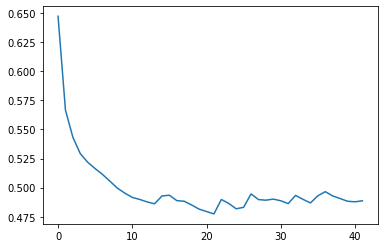

In [18]:
# plot losses
plt.plot(clf.history['loss'])

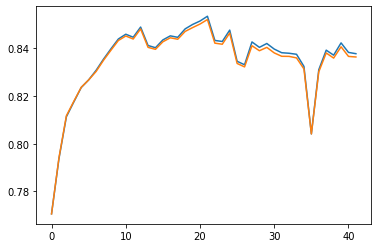

In [19]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

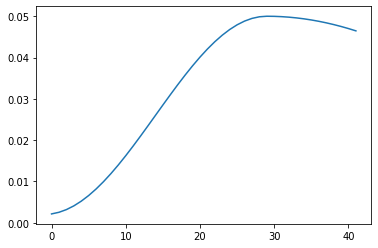

In [20]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [21]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

# print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL TEST SCORE FOR higgs-boson : 0.8511090237360007


In [22]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [23]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [24]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [25]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR higgs-boson : 0.8511090237360007


In [26]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [27]:
clf.feature_importances_

array([4.93633423e-02, 1.14320368e-02, 2.34090511e-07, 4.75387147e-02,
       1.39120104e-02, 4.06026045e-02, 8.98163477e-03, 1.37136256e-04,
       2.93641683e-02, 3.08700628e-02, 3.36996581e-05, 3.96840790e-08,
       1.23791578e-02, 2.19805461e-02, 8.01702879e-13, 9.08085764e-08,
       2.11360858e-02, 4.32132242e-02, 1.85621688e-07, 1.22334043e-02,
       3.50651040e-02, 8.78921036e-02, 4.35406332e-02, 5.74015691e-02,
       1.25844961e-01, 1.10493055e-01, 9.54113115e-02, 1.01172884e-01])

# Local explainability and masks

In [28]:
explain_matrix, masks = clf.explain(X_test)

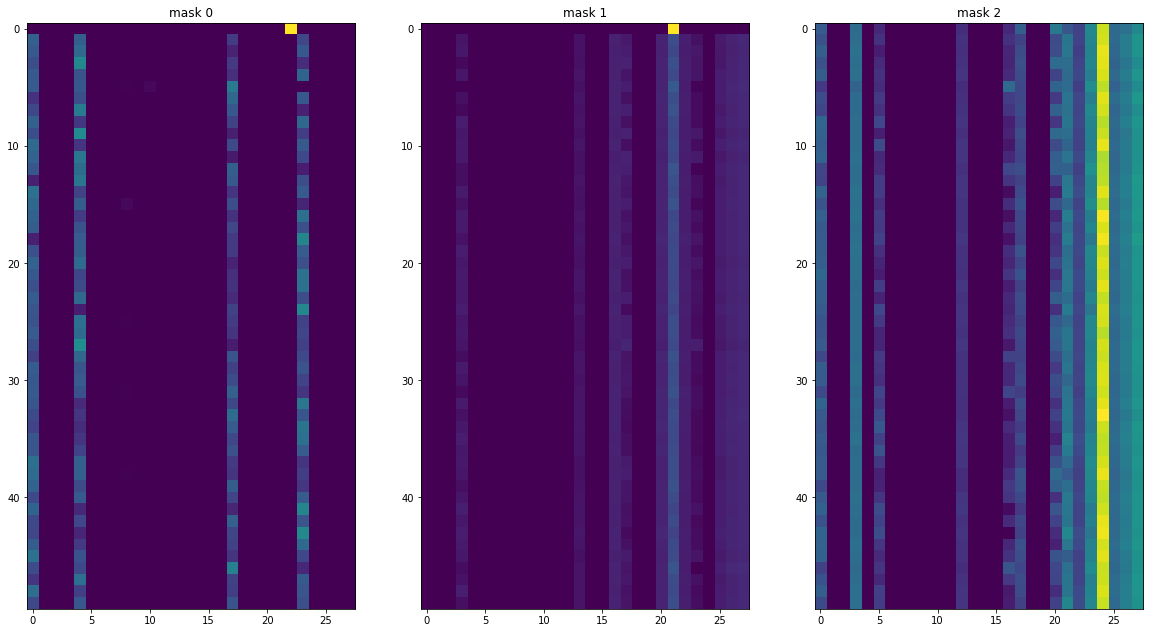

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
